The purpose of this notebook is to expose the causal structure underlying territorial polarisation in 1980-2020 France through canonical regression methods. The causal models we will discover will help discriminating between numerous qualitative assesments of this dynamics.

It is essentially based on the statsmodels library (Seabold, S., & Perktold, J. (2010). Statsmodels: Econometric and Statistical Modeling with Python. Proceedings of the 9th Python in Science Conference, 2010.).

In addition, we adapted the SESHAT regression methodology (Turchin, P. (2018). Fitting Dynamic Regression Models to Seshat Data. 35.), which was designed to handle both within- and between-areas interactions in cultural evolution, to adress similar dynamics in economic geography.

In [1]:
    ### Importing libraries ###

import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

import geopandas as gpd
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import plot_ccpr_grid


In [2]:
### Importing ZE1990 data ###

area_ZE1990 = pd.read_json("../Data processing/Output/area_ZE1990.json", typ="series")
dist_matrix_ZE1990 = pd.read_json("../Data processing/Output/dist_matrix_ZE1990.json")

dUC_timeseries_ZE1990 = pd.read_json("../Data processing/Output/dUC_timeseries_ZE1990.json")
d1_timeseries_ZE1990 = pd.read_json("../Data processing/Output/d1_timeseries_ZE1990.json")
med_timeseries_ZE1990 = pd.read_json("../Data processing/Output/med_timeseries_ZE1990.json")
d9_timeseries_ZE1990 = pd.read_json("../Data processing/Output/d9_timeseries_ZE1990.json")
moy_timeseries_ZE1990 = pd.read_json("../Data processing/Output/moy_timeseries_ZE1990.json")
intQ_timeseries_ZE1990 = pd.read_json("../Data processing/Output/intQ_timeseries_ZE1990.json")


In [3]:
### Importing ZE2010 data ###

area_ZE2010 = pd.read_json("../Data processing/Output/area_ZE2010.json", typ="series")
dist_matrix_ZE2010 = pd.read_json("../Data processing/Output/dist_matrix_ZE2010.json")

dUC_timeseries_ZE2010 = pd.read_json("../Data processing/Output/dUC_timeseries_ZE2010.json")
d1_timeseries_ZE2010 = pd.read_json("../Data processing/Output/d1_timeseries_ZE2010.json")
med_timeseries_ZE2010 = pd.read_json("../Data processing/Output/med_timeseries_ZE2010.json")
d9_timeseries_ZE2010 = pd.read_json("../Data processing/Output/d9_timeseries_ZE2010.json")
## moy_timeseries_ZE2010 = pd.read_json("../Data processing/Output/moy_timeseries_ZE2010.json")
intQ_timeseries_ZE2010 = pd.read_json("../Data processing/Output/intQ_timeseries_ZE2010.json")

tert_timeseries_ZE2010 = pd.read_json("../Data processing/Output/tert_timeseries_ZE2010.json")

In [4]:
### Importing other data

foreigndebt_timeseries = pd.read_json("../Data processing/Output/foreigndebt_timeseries.json")
foreigncapitals_timeseries = pd.read_json("../Data processing/Output/foreigncapitals_timeseries.json")

We will below implement a global prediction of polarisation levels from financiarisation and productivity disparities

In [5]:
### Extracting D1 and D9 index for ZE1990 and ZE2010 data

def D1D9_polarisation(med_timeseries, bottom_timeseries, top_timeseries, D1D9_number):
    top_index = med_timeseries.mean().nlargest(D1D9_number).index
    bottom_index = med_timeseries.mean().nsmallest(D1D9_number).index
    
    D1D9_pol = np.log(top_timeseries[top_index]).mean(axis=1) -  np.log(bottom_timeseries[bottom_index]).mean(axis=1)
    
    return(D1D9_pol)

D1D9_number = 25

In [20]:
### Regression on global polarisation (static)

    ## Defining exog (with centered regressors)
X = pd.DataFrame(index = range(1999, 2018))

X["Intercept"] = 1
X["Dette étrangère"] = np.log(foreigndebt_timeseries)
X["Capitaux étrangers"] = np.log(foreigncapitals_timeseries)
X["Polarisation de la composition sectorielle"] = D1D9_polarisation(med_timeseries_ZE2010, tert_timeseries_ZE2010, tert_timeseries_ZE2010, D1D9_number)

X[X.columns[1:]] = X[X.columns[1:]]-X[X.columns[1:]].mean() ### centering all columns but intercept

    ## Defining endog
y = pd.DataFrame(index = range(2001,2018))

y["Polarisation des revenus"] = pd.concat([D1D9_polarisation(med_timeseries_ZE1990, d1_timeseries_ZE1990, d9_timeseries_ZE1990, D1D9_number), D1D9_polarisation(med_timeseries_ZE2010, d1_timeseries_ZE2010, d9_timeseries_ZE2010, D1D9_number)])

    ## Regressing
results = sm.GLS(y, X.loc[y.index]).fit()

print(results.summary())

                               GLS Regression Results                               
Dep. Variable:     Polarisation des revenus   R-squared:                       0.627
Model:                                  GLS   Adj. R-squared:                  0.541
Method:                       Least Squares   F-statistic:                     7.280
Date:                      Thu, 06 Aug 2020   Prob (F-statistic):            0.00412
Time:                              11:32:12   Log-Likelihood:                 42.506
No. Observations:                        17   AIC:                            -77.01
Df Residuals:                            13   BIC:                            -73.68
Df Model:                                 3                                         
Covariance Type:                  nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

/home/avel/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


In [21]:
### Regression on global polarisation (dynamic)

    ## Defining exog
X = pd.DataFrame(index = range(1999, 2018))
X["Intercept"] = 1

X["Dette étrangère"] = np.log(foreigndebt_timeseries)
X["Capitaux étrangers"] = np.log(foreigncapitals_timeseries)
X["Polarisation de la composition sectorielle"] = D1D9_polarisation(med_timeseries_ZE2010, tert_timeseries_ZE2010, tert_timeseries_ZE2010, D1D9_number)
X["Polarisation des revenus"] = pd.concat([D1D9_polarisation(med_timeseries_ZE1990, d1_timeseries_ZE1990, d9_timeseries_ZE1990, D1D9_number), D1D9_polarisation(med_timeseries_ZE2010, d1_timeseries_ZE2010, d9_timeseries_ZE2010, D1D9_number)])

X = X.dropna()
X[X.columns[1:]] = X[X.columns[1:]]-X[X.columns[1:]].mean() ### centering all columns but intercept

    ## Defining endog
y = pd.DataFrame(index = range(1999,2018))

y["Variation annuelle de la polarisation des revenus"] = X["Polarisation des revenus"].diff().shift(-1)
y = y.dropna()

    ## Regressing
results = sm.GLS(y, X.loc[y.index]).fit()

print(results.summary())

                                            GLS Regression Results                                           
Dep. Variable:     Variation annuelle de la polarisation des revenus   R-squared:                       0.574
Model:                                                           GLS   Adj. R-squared:                  0.419
Method:                                                Least Squares   F-statistic:                     3.709
Date:                                               Thu, 06 Aug 2020   Prob (F-statistic):             0.0379
Time:                                                       11:32:14   Log-Likelihood:                 47.664
No. Observations:                                                 16   AIC:                            -85.33
Df Residuals:                                                     11   BIC:                            -81.46
Df Model:                                                          4                                         
Covariance

/home/avel/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


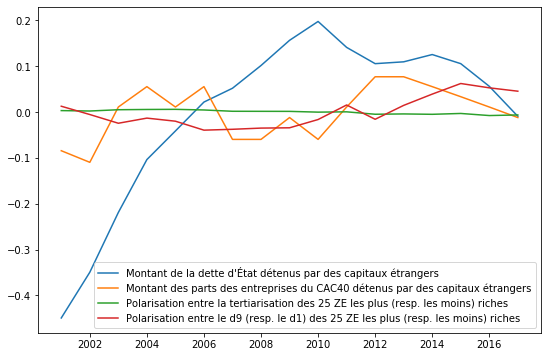

In [23]:
### Drawing data

fig = plt.figure(figsize=(9,6))

X_plot = X

plt.plot(X_plot["Dette étrangère"], label="Montant de la dette d'État détenus par des capitaux étrangers")
plt.plot(X_plot["Capitaux étrangers"], label="Montant des parts des entreprises du CAC40 détenus par des capitaux étrangers")
plt.plot(X_plot["Polarisation de la composition sectorielle"], label="Polarisation entre la tertiarisation des " + str(D1D9_number) + " ZE les plus (resp. les moins) riches")
plt.plot(X_plot["Polarisation des revenus"], label="Polarisation entre le d9 (resp. le d1) des " + str(D1D9_number) + " ZE les plus (resp. les moins) riches")

plt.legend()

plt.savefig("Global regression variables.png")
plt.show()

In [24]:
### Defining data for regression on local polarisation proxies (ZE1990)

    ## Defining endog
X = pd.DataFrame(index=pd.MultiIndex.from_product([med_timeseries_ZE1990.columns, range(2001,2009)]))
X["Intercept"] = 1

X["UC density"] = np.log(dUC_timeseries_ZE1990).stack().swaplevel()
X["Median revenue"] = np.log(med_timeseries_ZE1990).stack().swaplevel()
X["Interdecile quotient"] = np.log(intQ_timeseries_ZE1990).stack().swaplevel()

markpot_ZE1990 = (med_timeseries_ZE1990*dUC_timeseries_ZE1990*area_ZE1990).dot((1/dist_matrix_ZE1990).replace([np.inf, -np.inf], 1))
X["Market potential"] = np.log(markpot_ZE1990).stack().swaplevel()

X[X.columns[1:]] = X[X.columns[1:]]-X[X.columns[1:]].mean() ### centering all columns but intercept
X = X.dropna()

    
    ## Defining exog
y = pd.DataFrame(index=pd.MultiIndex.from_product([med_timeseries_ZE1990.columns, range(2001,2009)]))

y["UC density"] = np.log(dUC_timeseries_ZE1990).diff().shift(-1).stack().swaplevel()
y["Median revenue"] = np.log(med_timeseries_ZE1990).diff().shift(-1).stack().swaplevel()
y["Interdecile quotient"] = np.log(intQ_timeseries_ZE1990).diff().shift(-1).stack().swaplevel()

y = y.dropna()

In [25]:
    ## Regressing on UC density
results = sm.GLS(y["UC density"], X.loc[y.index]).fit()

print(results.summary())

                            GLS Regression Results                            
Dep. Variable:             UC density   R-squared:                       0.115
Model:                            GLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     79.08
Date:                Thu, 06 Aug 2020   Prob (F-statistic):           3.83e-63
Time:                        11:34:10   Log-Likelihood:                 7738.8
No. Observations:                2430   AIC:                        -1.547e+04
Df Residuals:                    2425   BIC:                        -1.544e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0125 

In [26]:
    ## Regressing on med revenue
results = sm.GLS(y["Median revenue"], X.loc[y.index]).fit()

print(results.summary())

                            GLS Regression Results                            
Dep. Variable:         Median revenue   R-squared:                       0.083
Model:                            GLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     54.72
Date:                Thu, 06 Aug 2020   Prob (F-statistic):           3.18e-44
Time:                        11:34:12   Log-Likelihood:                 8683.9
No. Observations:                2430   AIC:                        -1.736e+04
Df Residuals:                    2425   BIC:                        -1.733e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0321 

In [27]:
    ## Regressing on interdecile quotient
results = sm.GLS(y["Interdecile quotient"], X.loc[y.index]).fit()

print(results.summary())

                             GLS Regression Results                             
Dep. Variable:     Interdecile quotient   R-squared:                       0.046
Model:                              GLS   Adj. R-squared:                  0.044
Method:                   Least Squares   F-statistic:                     29.05
Date:                  Thu, 06 Aug 2020   Prob (F-statistic):           1.26e-23
Time:                          11:34:15   Log-Likelihood:                 6090.5
No. Observations:                  2430   AIC:                        -1.217e+04
Df Residuals:                      2425   BIC:                        -1.214e+04
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept   

In [35]:
### Defining data for regression on local polarisation proxies (ZE2010)

    ## Defining endog
X = pd.DataFrame(index=pd.MultiIndex.from_product([med_timeseries_ZE2010.columns, range(2009,2017)]))
X["Intercept"] = 1

X["UC density"] = np.log(dUC_timeseries_ZE2010).stack().swaplevel()
X["Median revenue"] = np.log(med_timeseries_ZE2010).stack().swaplevel()
X["Interdecile quotient"] = np.log(intQ_timeseries_ZE2010).stack().swaplevel()

markpot_ZE2010 = (med_timeseries_ZE2010*dUC_timeseries_ZE2010*area_ZE2010).dot((1/dist_matrix_ZE2010).replace([np.inf, -np.inf], 1))
X["Market potential"] = np.log(markpot_ZE2010).stack().swaplevel()

X[X.columns[1:]] = X[X.columns[1:]]-X[X.columns[1:]].mean() ### centering all columns but intercept
X = X.dropna()
    
    ## Defining exog
y = pd.DataFrame(index=pd.MultiIndex.from_product([med_timeseries_ZE2010.columns, range(2009,2017)]))

y["UC density"] = np.log(dUC_timeseries_ZE2010).diff().shift(-1).stack().swaplevel()
y["Median revenue"] = np.log(med_timeseries_ZE2010).diff().shift(-1).stack().swaplevel()
y["Interdecile quotient"] = np.log(intQ_timeseries_ZE2010).diff().shift(-1).stack().swaplevel()

y = y.dropna()

In [37]:
    ## Regressing on UC density
results = sm.GLS(y["UC density"], X.loc[y.index]).fit()

print(results.summary())

                            GLS Regression Results                            
Dep. Variable:             UC density   R-squared:                       0.056
Model:                            GLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     36.30
Date:                Thu, 06 Aug 2020   Prob (F-statistic):           1.66e-29
Time:                        11:38:27   Log-Likelihood:                 7767.1
No. Observations:                2432   AIC:                        -1.552e+04
Df Residuals:                    2427   BIC:                        -1.550e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0017 

In [38]:
    ## Regressing on med revenue
results = sm.GLS(y["Median revenue"], X.loc[y.index]).fit()

print(results.summary())

                            GLS Regression Results                            
Dep. Variable:         Median revenue   R-squared:                       0.113
Model:                            GLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     77.63
Date:                Thu, 06 Aug 2020   Prob (F-statistic):           4.90e-62
Time:                        11:38:28   Log-Likelihood:                 8341.4
No. Observations:                2432   AIC:                        -1.667e+04
Df Residuals:                    2427   BIC:                        -1.664e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0188 

In [39]:
    ## Regressing on interdecile quotient
results = sm.GLS(y["Interdecile quotient"], X.loc[y.index]).fit()

print(results.summary())

                             GLS Regression Results                             
Dep. Variable:     Interdecile quotient   R-squared:                       0.035
Model:                              GLS   Adj. R-squared:                  0.034
Method:                   Least Squares   F-statistic:                     22.21
Date:                  Thu, 06 Aug 2020   Prob (F-statistic):           5.00e-18
Time:                          11:38:29   Log-Likelihood:                 5637.1
No. Observations:                  2432   AIC:                        -1.126e+04
Df Residuals:                      2427   BIC:                        -1.124e+04
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept   